## Network analysis of discussion threats on Reddit 

In [27]:
import praw
import pandas as pd
from datetime import datetime 
import networkx as nx 
import pickle
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
import glob
import matplotlib.pyplot as plt
import matplotlib

### Reddit instance with authorization information

In [ ]:
reddit = praw.Reddit(client_id='',
                     client_secret='',
                     user_agent='',
                     username= '', 
                     password= ''
                    )

print(reddit.user.me())
print(reddit.read_only)

### List of subreddits

In [3]:
sub_list = [
 'AskScienceDiscussion',
 'askscience',
 'climatechange',
 'conservatives',
 'AskTrumpSupporters',
 'climateskeptics'
]

## Comment Dataframe for multiple Subreddits

* Iterating through a list of subreddits
* Iterating through unlimmited number of hot submissions that contain the keyword "fire" in each subreddit
* Getting the comments for each submission
* Saving the author (if not deleted)
* Saving the comment body (if not deleted)
* Append dataframe-list with comment id, body, author name, upvotes, timestamp, comment level (depth) and parent id and subreddit name

In [4]:
df_list = []

for sub in sub_list:
    subreddit = reddit.subreddit(sub)
    for c, submission in enumerate(subreddit.hot(limit=None)):
        if "fire" in submission.title:
            for c,comment in enumerate(submission.comments.list()):
                # THe try exists because some reddit comments are from authors who 
                # have deleted their account, but the comments persist. 
                try:
                    x = comment.author.name,
                    authorname = x[0]
                except AttributeError:
                    authorname = "[deleted]"
            
                try:
                    comment_body = comment.body,
                except AttributeError:
                    comment_body = "[deleted]"
            
                try: 
                    df_list.append([ \
                    comment.id,
                    comment_body,
                    authorname,
                    comment.ups,
                    comment.created_utc,
                    comment.depth,
                    comment.parent_id[3:],
                    subreddit
                    ])
                except AttributeError:
                    continue
                    
reddit_df = pd.DataFrame(df_list,columns=["id","body","authorname","ups","created_utc","depth","parent_id","subreddit"])

In [5]:
# create datetime object
reddit_df["date"] = reddit_df["created_utc"].map(lambda x: datetime.utcfromtimestamp(x))

display(reddit_df.head(10))
reddit_df.shape

,id,body,authorname,ups,created_utc,depth,parent_id,subreddit,date
0,fktjz0a,(Yep. You could do this experiment now. Li...,Abyss_of_Dreams,2,1.584523e+09,0,fkmq0d,AskScienceDiscussion,2020-03-18 09:21:44
1,fktka9j,"(Also, this is how those fire blankets work,)",PivotPsycho,1,1.584524e+09,0,fkmq0d,AskScienceDiscussion,2020-03-18 09:28:41
2,fkghpja,(No where near close to the speed of light. It...,thenumber1326,7,1.584160e+09,0,fic5q9,AskScienceDiscussion,2020-03-14 04:28:09
3,fkgqsh5,"(120 meters per second,)",sunceramics,3,1.584170e+09,0,fic5q9,AskScienceDiscussion,2020-03-14 07:12:01
4,fkof6et,(Almost like you could find this answer in a m...,pickles1486,1,1.584386e+09,0,fic5q9,AskScienceDiscussion,2020-03-16 19:13:15
5,fkofb3h,"(Imagine socializing,)",Nick-Conner,1,1.584386e+09,1,fkof6et,AskScienceDiscussion,2020-03-16 19:14:30
6,firpb10,(Are you talking about [one of these?](https:/...,ironscythe,1,1.582669e+09,0,f9i01c,AskScienceDiscussion,2020-02-25 22:12:46
7,fisg0op,"(You don’t have a picture?,)",14nicholas14,1,1.582684e+09,0,f9i01c,AskScienceDiscussion,2020-02-26 02:29:07
8,firpkd7,"(No, I’m talking about a small handball with t...",joedabro56,3,1.582669e+09,1,firpb10,AskScienceDiscussion,2020-02-25 22:15:19
9,fisi0mk,"(How do I do that lol,)",joedabro56,0,1.582685e+09,1,fisg0op,AskScienceDiscussion,2020-02-26 02:46:53


(1141, 9)

In [6]:
# Store data (serialize)
with open('fire_reddit_df.pickle', 'wb') as handle:
    pickle.dump(reddit_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Load data (deserialize)
with open('fire_reddit_df.pickle', 'rb') as handle:
    fire_df = pickle.load(handle)

print(fire_df.shape)

# also save dataframe as csv 
reddit_df.to_csv('fire_reddit_comments_df.csv', encoding='utf-8', index=False)

(1141, 9)


## Create comment tree (acyclic graph) for each subreddit

In [7]:
for sub in sub_list:
    
    G = nx.DiGraph()
    
    node_set = set([])
    
    subreddit = reddit.subreddit(sub)
    
    for submission in subreddit.hot(limit=None):
        if "fire" in submission.title:
            submission.comments.replace_more(limit=None)
            
            for i in submission.comments.list():
                try:
                    G.add_node(i.id, depth=i.depth,name=i.author.name)
                except AttributeError: 
                    G.add_node(i.id, depth=i.depth,name="[Deleted]")
                node_set.add(i.id)
            
            for i in submission.comments.list():
                if i.parent_id and i.parent_id[3:] in node_set:
                    G.add_edge(i.id,i.parent_id[3:])
    
    print(subreddit,G.number_of_nodes(),'nodes')

    nx.write_gexf(G,('%s.gexf'%subreddit))

AskScienceDiscussion 43 nodes
askscience 156 nodes
climatechange 642 nodes
conservatives 83 nodes
AskTrumpSupporters 139 nodes
climateskeptics 144 nodes


## Analysis of comment graphs 

* careful with comparisons between graphs! Valid assumptions only within graphs possible
* multiple graphs for the purpose of validation, to see different structures 

#### First descriptive information 

In [2]:
files = glob.glob('*.gexf')

graph_dict = {}

for graph in files:
    
    g = nx.read_gexf(graph)
    graph_dict[graph] = g
    
    # geth info about nodes, edges, average in-degree and out-degree for all graphs
    print('\033[1m' + graph)
    print('\033[0m' + nx.info(g))
    print()

askscience.gexf
Name: 
Type: DiGraph
Number of nodes: 156
Number of edges: 136
Average in degree:   0.8718
Average out degree:   0.8718

AskScienceDiscussion.gexf
Name: 
Type: DiGraph
Number of nodes: 43
Number of edges: 30
Average in degree:   0.6977
Average out degree:   0.6977

AskTrumpSupporters.gexf
Name: 
Type: DiGraph
Number of nodes: 139
Number of edges: 114
Average in degree:   0.8201
Average out degree:   0.8201

climatechange.gexf
Name: 
Type: DiGraph
Number of nodes: 642
Number of edges: 481
Average in degree:   0.7492
Average out degree:   0.7492

climateskeptics.gexf
Name: 
Type: DiGraph
Number of nodes: 144
Number of edges: 102
Average in degree:   0.7083
Average out degree:   0.7083

conservatives.gexf
Name: 
Type: DiGraph
Number of nodes: 83
Number of edges: 45
Average in degree:   0.5422
Average out degree:   0.5422



### Degree distributions

askscience.gexf
The average degree is 1.74.


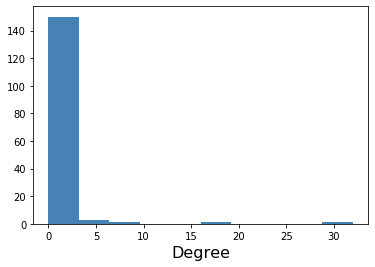


AskScienceDiscussion.gexf
The average degree is 1.40.


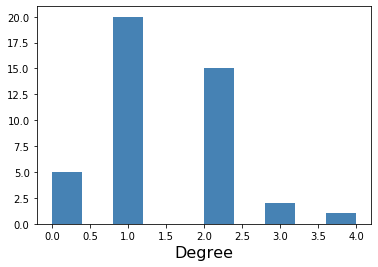


AskTrumpSupporters.gexf
The average degree is 1.64.


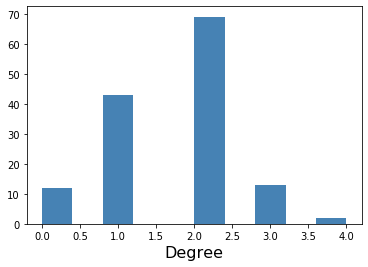


climatechange.gexf
The average degree is 1.50.


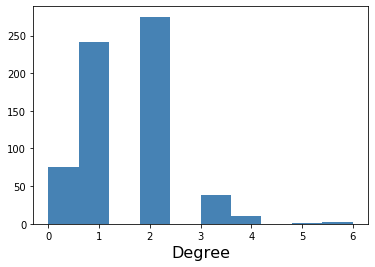


climateskeptics.gexf
The average degree is 1.42.


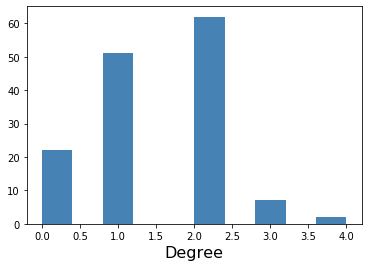


conservatives.gexf
The average degree is 1.08.


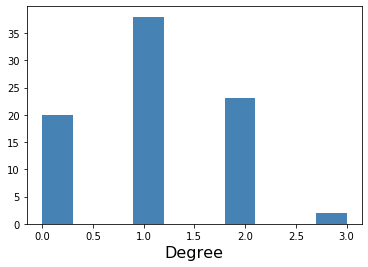

In [13]:
for graph, g in graph_dict.items():
    print('\033[1m' + graph)
    result = nx.degree(g) # Gather node degrees into a list
    deg_series = pd.Series(dict(result)) # Create degree series
    print('\033[0m' + "The average degree is {:.2f}.".format(deg_series.mean()))
    
    fig, ax = plt.subplots() 
    degplot = deg_series.hist(color='steelblue',grid=False); # display degree distribution
    degplot.set_xlabel("Degree", size = 16)
    #degplot.set_title(graph, size = 16)
    
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(6,4)
    fig.savefig('degree_barplot_{}.png'.format(graph), dpi=200)
    
    plt.show()
    print()

## Weakly connected components

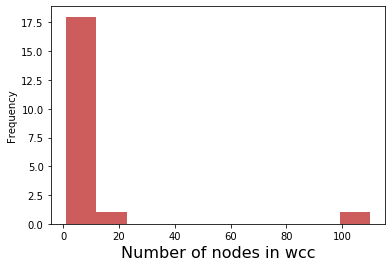

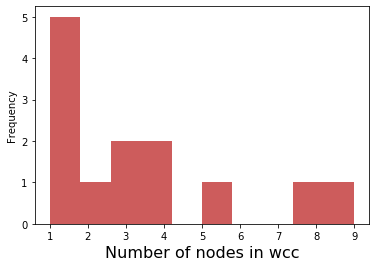

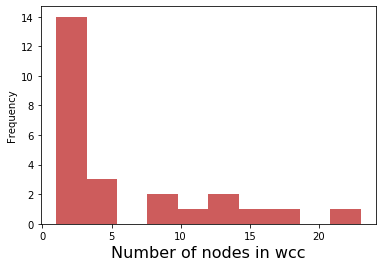

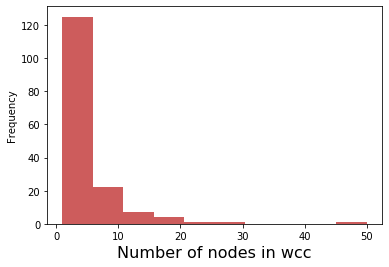

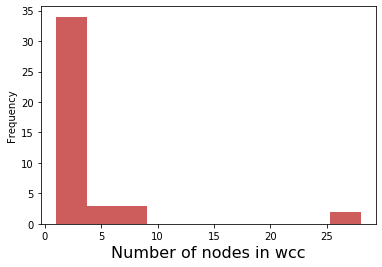

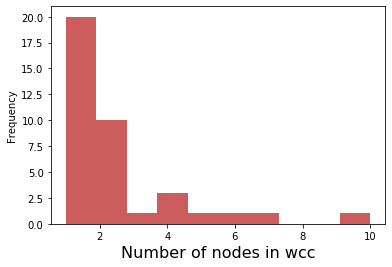

In [74]:
for graph, g in graph_dict.items():
    
    wcc = pd.Series([g.subgraph(c).number_of_nodes() for c in nx.weakly_connected_component_subgraphs(g)])
    
    fig, ax = plt.subplots() 
    wccplot = wcc.plot(kind='hist',color='indianred')
    wccplot.set_xlabel("Number of nodes in wcc", size = 16)
    
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(6,4)
    fig.savefig('wcc_barplot_{}.png'.format(graph), dpi=200)
    
    plt.show()
    print()

## Largest weakly connected components (Giant Components)

Populating the interactive namespace from numpy and matplotlib


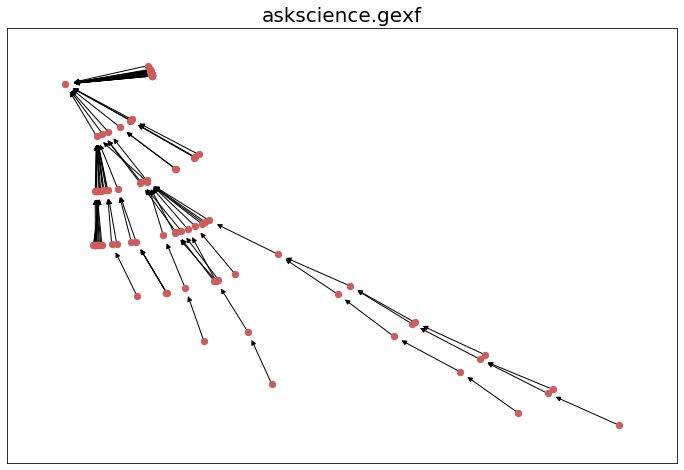

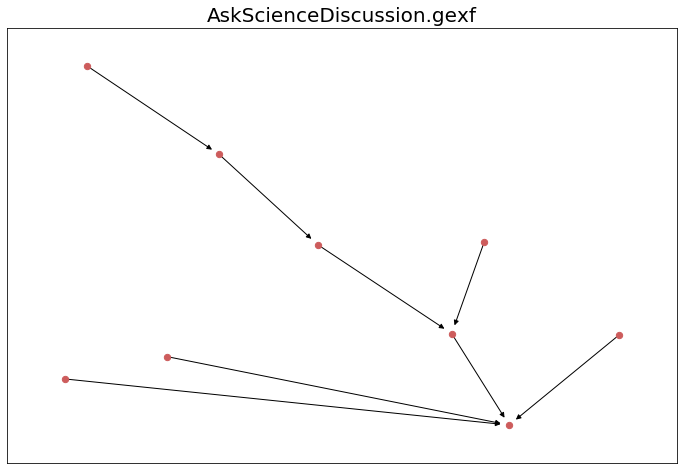

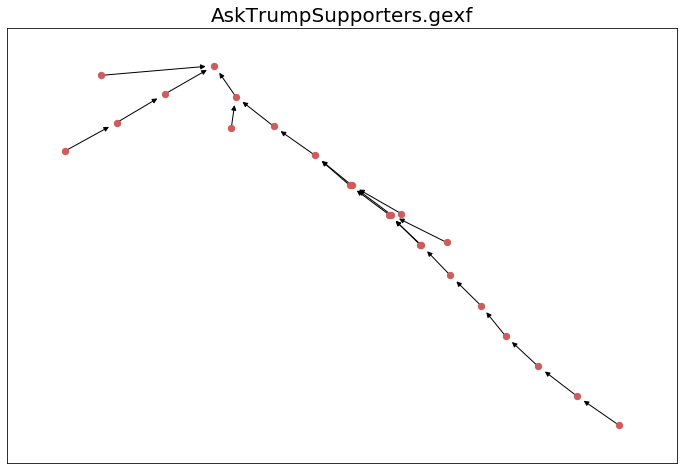

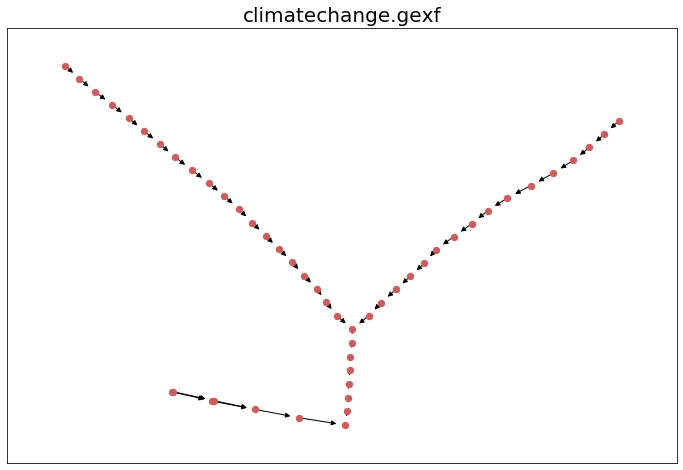

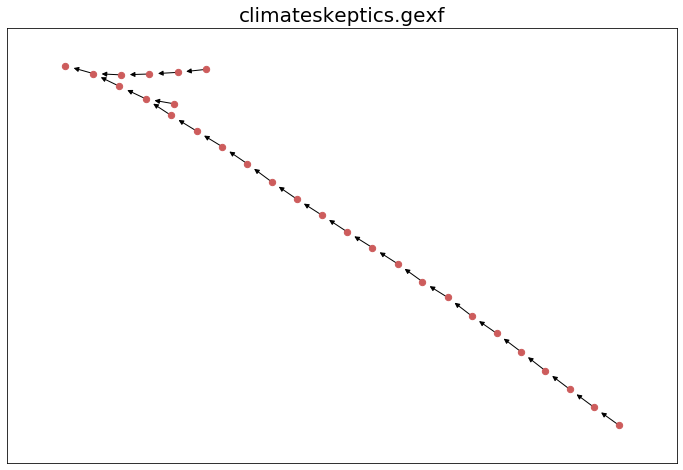

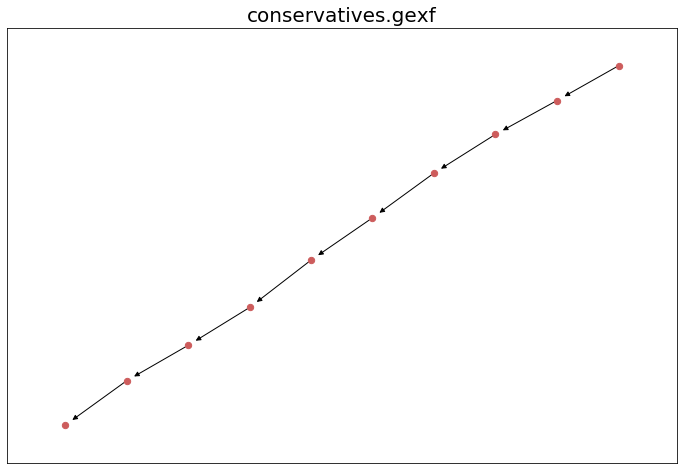

In [87]:
# plot largest weakly connected component (giant component)
%pylab inline

for graph, g in graph_dict.items():
    plt.figure(graph)
    plt.title(graph, size=20)
    
    Gc = max(nx.weakly_connected_component_subgraphs(g), key=len)
    pos=nx.kamada_kawai_layout(Gc)
    
    nx.draw_networkx_nodes(Gc,pos,node_size=40, node_color = "indianred")
    nx.draw_networkx_edges(Gc,pos)
    
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(12,8)
    fig.savefig('Gc_{}.png'.format(graph), dpi=200)
    
    plt.show()
    print()

### Showing giant component in context of all comments
Spring-layout was used to display the root comments on the outer ring of the graph so that the comment trees develop towards the middle of the graph. It is not an ideal layout but I could get an intuitive understanding of the comment structure of apparently structurally very different snapshots of subreddits (e.g. conservatives, askscience and climatechange).

Populating the interactive namespace from numpy and matplotlib


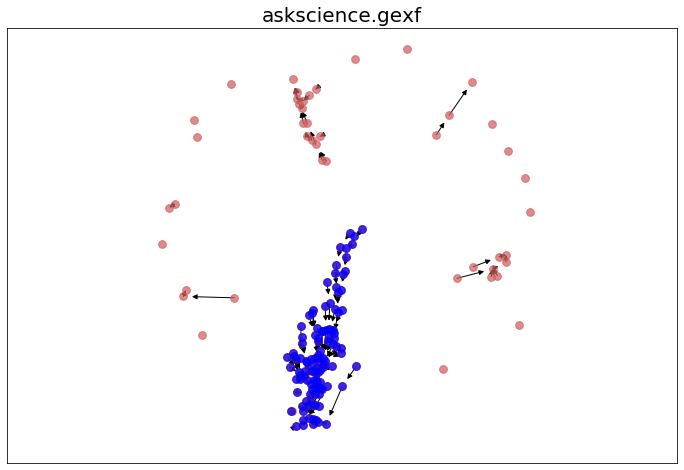

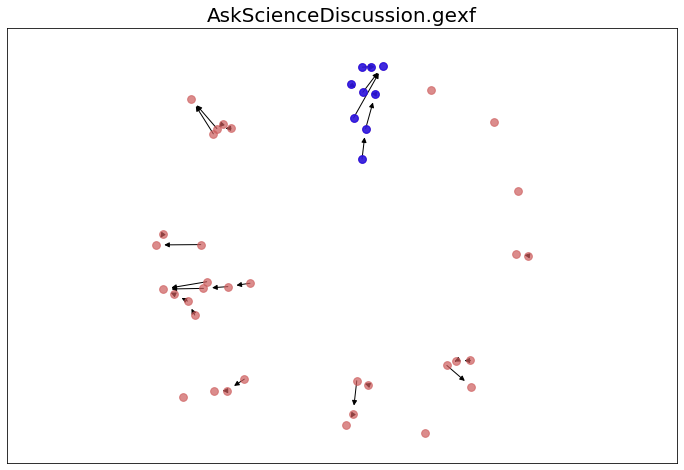

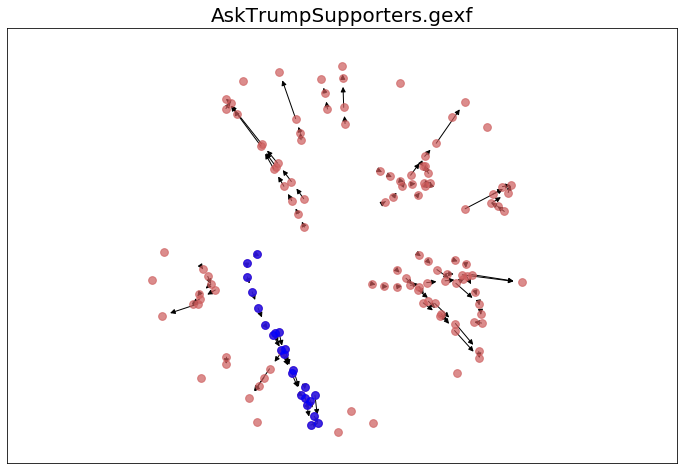

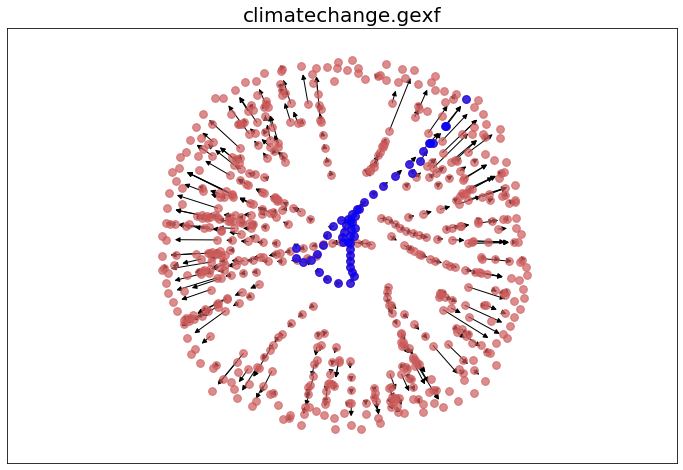

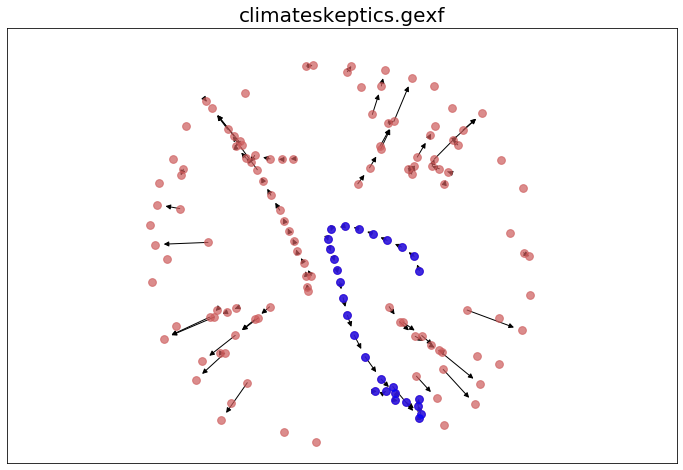

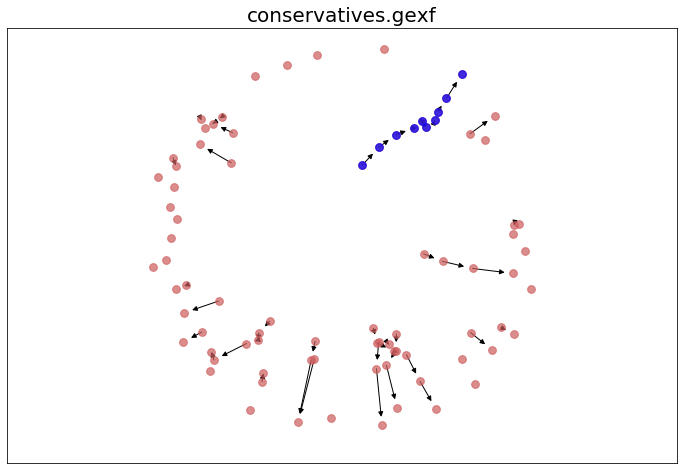

In [82]:
%pylab inline

for graph, g in graph_dict.items():
    
    ax = plt.subplots(figsize=(15, 15))
    pos=nx.spring_layout(g)
    
    plt.title(graph, size=20)
    
    nx.draw_networkx_nodes(g,pos,node_size=60,node_color = "indianred",alpha = 0.7)
    
    Gc = max(nx.weakly_connected_component_subgraphs(g), key=len)
    nx.draw_networkx_nodes(Gc,pos,node_size=60, node_color = "blue", alpha = 0.7)
    nx.draw_networkx_edges(g,pos)
    
    plt.axis('equal')
    
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(12,8)
    fig.savefig('graph_{}.png'.format(graph), dpi=200)
    
    plt.show()
    print()

### Visualization of all connected components of the discussion threats within a subreddit

In [17]:
# clean graph from isolates first

def clean_graph(G,no_isolates=True):
    label_dict = {j:i for i,j in enumerate(G.nodes) }
    edge_set = set()
    for i in G.edges:
        il = list(i)
        il.sort()
        edge_set.add((label_dict[il[0]],label_dict[il[1]]))
    cleang = nx.DiGraph()
    cleang.add_nodes_from(label_dict.values())
    cleang.add_edges_from(edge_set)     
    # Now to remove the isolates
    if no_isolates: 
        cleang.remove_nodes_from(list(nx.isolates(cleang)))
    return cleang

Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


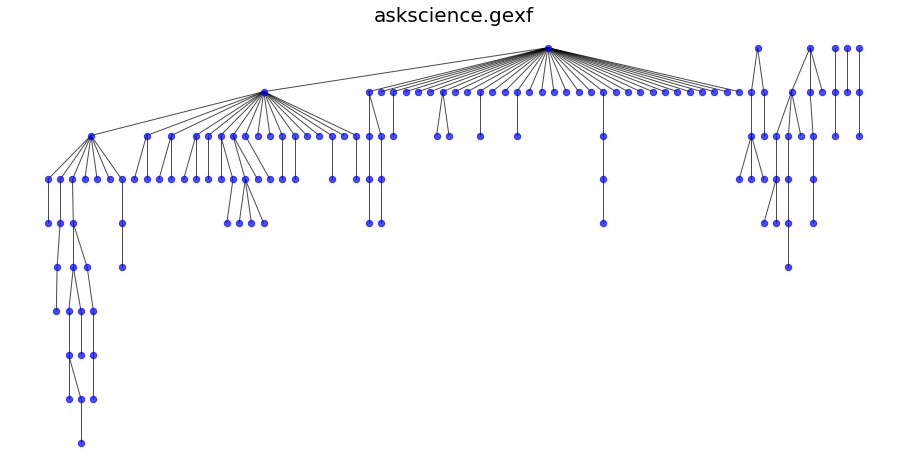

/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


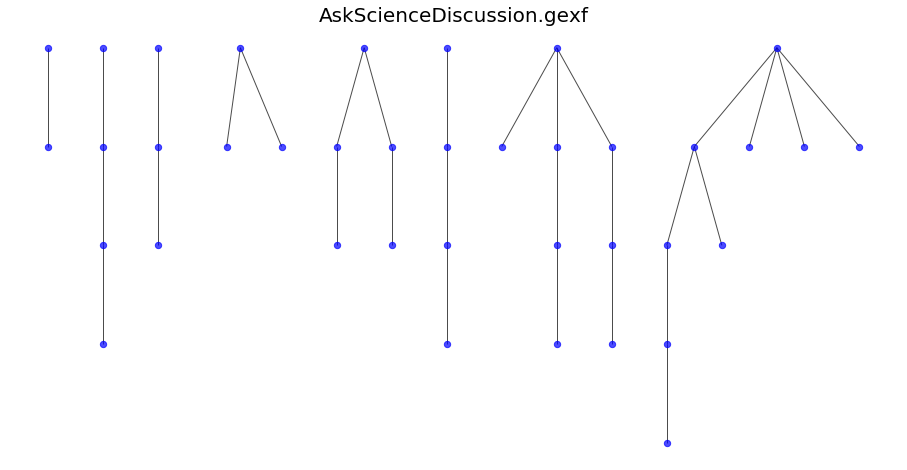

/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


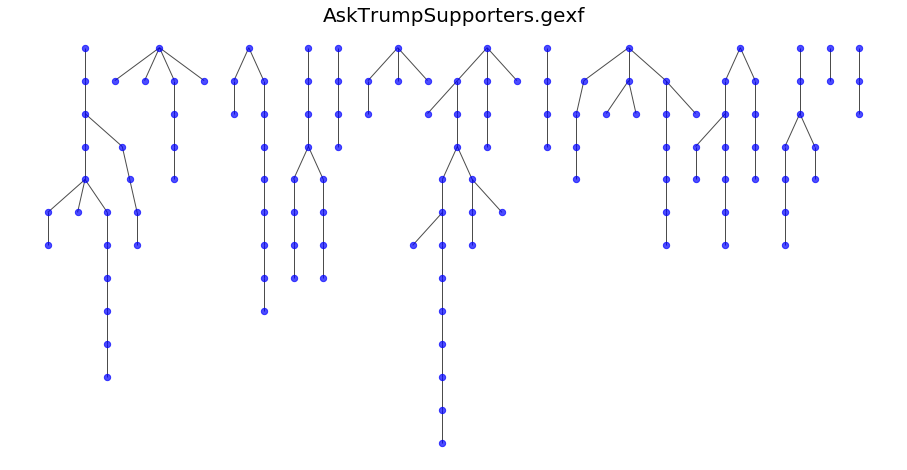

/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


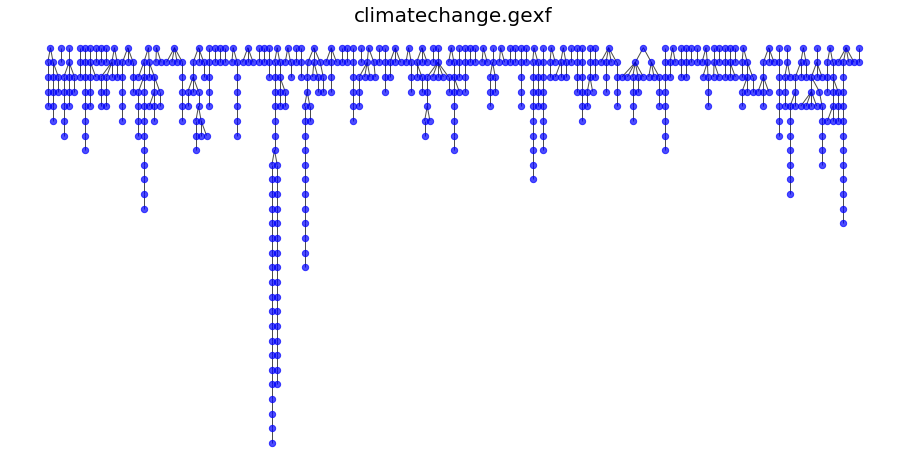

/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


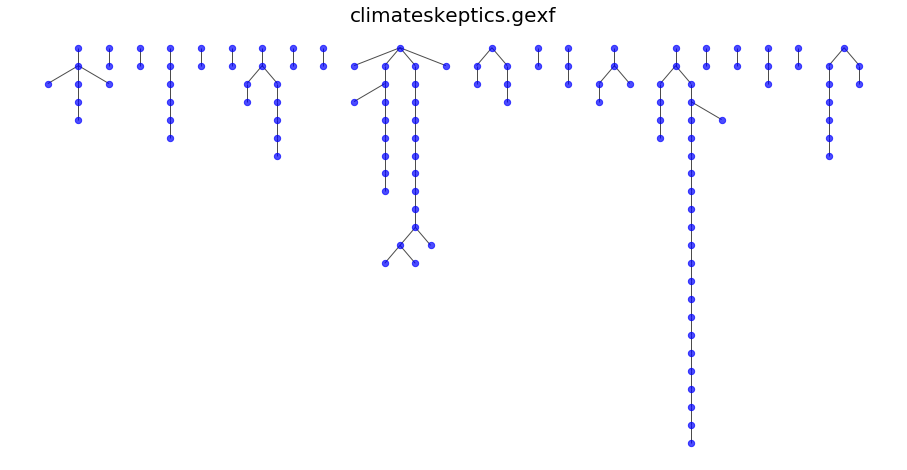

/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


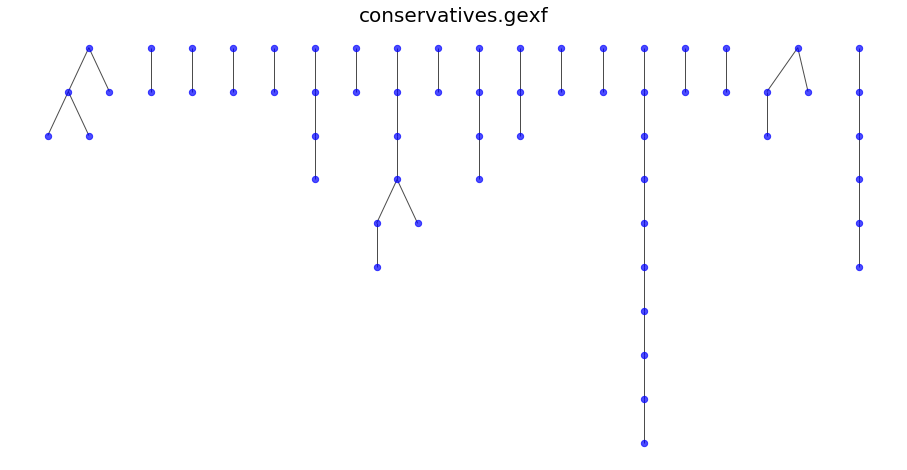

In [83]:
%pylab inline

for graph, g in graph_dict.items():
    
    ax = plt.subplots(figsize=(15, 15))
    
    pos = graphviz_layout(clean_graph(g), prog='dot')
    nx.draw(clean_graph(g), pos, node_size=40, node_color="blue", alpha=0.7, with_labels=False, arrows = False)
    
    plt.title(graph, size = 20)
    
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(16,8)
    fig.savefig('comments_{}.png'.format(graph), dpi=200)
    
    plt.show()
    print()

# Analysis of Discussion Threats 

### Widest Discussion Threats (in-degree) 
* determine the width of discussion on each level of depth
* In-degree: number of edges that point to a node. 
* A high in-degree as indicator for lots of replies / a wide discussion threat / the involvement of many different people (one dimension of Gonzalez-Bailon's deliberation concept) 

In [3]:
# import dataframe from pickle 

# Load data (deserialize)
with open('fire_reddit_df.pickle', 'rb') as handle:
    reddit_df = pickle.load(handle)

print(reddit_df.shape)

(1141, 9)


In [4]:
all_max_replies_per_depth = pd.DataFrame()

for graph,g in graph_dict.items():

    # turn in-degrees of nodes (comments) into dictionary and then into dataframe
    deg_df = pd.DataFrame.from_dict(dict(g.in_degree()), orient="index",columns=["in_degree"])
    
    deg_df['subreddit'] = graph
    
    # get depth for each comment
    deg_df['depth'] = pd.Series(dict([(i,g.nodes[i]['depth']) for i in g.nodes])) 
    
    df_list = []
    
    # group py depth
    for i,j in deg_df.groupby("depth"):
        df_list.append(j[j["in_degree"] == max(j["in_degree"])].copy())
        max_replies_per_depth = pd.concat(df_list)
        
    all_max_replies_per_depth = all_max_replies_per_depth.append(max_replies_per_depth)
        
reddit_df_2 = all_max_replies_per_depth.merge(reddit_df,left_index=True, right_on="id")
reddit_df_2 = reddit_df_2.drop(columns=['depth_y'])
reddit_df_2['body'] = reddit_df_2['body'].map(lambda all_max_replies_per_depth : all_max_replies_per_depth[0])
display(reddit_df_2.head())

,in_degree,subreddit_x,depth_x,id,body,authorname,ups,created_utc,parent_id,subreddit_y,date
43,32,askscience.gexf,0,fjys8mz,Its a chemical reaction in their gut where an ...,nofapdutchmen,5116,1.583703e+09,ffj6gb,askscience,2020-03-08 21:38:03
61,17,askscience.gexf,1,fjytytm,This is correct. The chemical is called “[Luci...,xonacatl,1509,1.583705e+09,fjys8mz,askscience,2020-03-08 21:55:33
101,7,askscience.gexf,2,fjywxc0,"Interesting tidbit about these chemicals, Luci...",teqqqie,357,1.583706e+09,fjytytm,askscience,2020-03-08 22:25:31
150,3,askscience.gexf,3,fjzbsgt,I would think it would have more to do with Lu...,norathar,59,1.583716e+09,fjzbe50,askscience,2020-03-09 01:07:09
168,2,askscience.gexf,4,fjz6hqx,"That's awesome! If you don't mind me asking, w...",teqqqie,9,1.583713e+09,fjz5trt,askscience,2020-03-09 00:08:24


depth_x,0,1,2,3,4,5,6,7,8,9
subreddit,,,,,,,,,,
AskScienceDiscussion,4,2,1,1,0,0,0,0,0,0
AskTrumpSupporters,4,2,2,2,3,2,1,1,1,1
askscience,32,17,7,3,2,2,1,2,1,0
climatechange,4,5,3,4,2,2,1,2,1,1
climateskeptics,4,3,2,2,1,1,1,1,1,1
conservatives,2,2,1,2,1,1,1,1,1,0


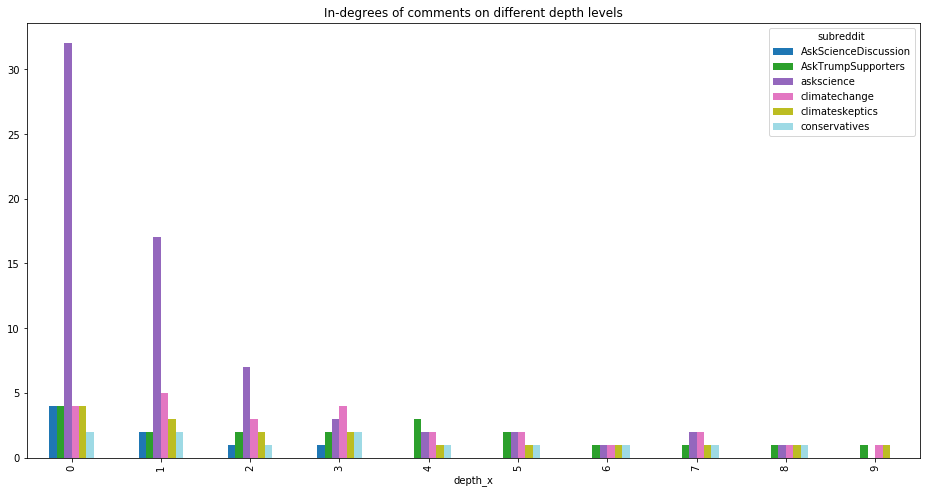

In [5]:
reddit_df_2["subreddit"] = reddit_df_2["subreddit_y"].apply(str)
width_table = pd.pivot_table(reddit_df_2, 
                             index=['subreddit'],
                             columns=['depth_x'], 
                             values='in_degree',
                             aggfunc='mean') # mean does not really aggregate information, somethimes the same value 
                                             # occurs multiple times because some comments have same in-degree


width_table = width_table.fillna(0).astype(int)
display(width_table)

# plot width distribution

width_table.T.plot(kind='bar',
                   title='In-degrees of comments on different depth levels',
                   colormap = 'tab20'
                  )

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16,8)
fig.savefig('width_plot.png'.format(graph), dpi=200)

width_table.to_latex('width_table.tex')

Interpretation: look at maximal in-degrees for each depth-level for each subreddit

Some subreddits are characterized by high in-degrees (on various levels) e.g. askscience, showing a rather wide discussion threat in which multiple people are involved, while others have low in-degrees (e.g. conservatives. This might be an indicator for a narrow but maybe deep discussion threat, e.g. because two redditors have a conflict and reply repeatedly to each other). 

### Longest Discussion Threats (maximal depth of comment tree)

Here I will access the longest-path of the comment branch to determine the maximal length of discussion threats for each subreddit.
This number should align with the depth_x in the table of in-degrees above.

In [6]:
max_depth_df = pd.DataFrame()

for graph,g in graph_dict.items():
    
    longest_path_comment_branch = list(nx.dag_longest_path(g))
    lpcb_df =reddit_df[reddit_df["id"].isin(longest_path_comment_branch)]
    temp_sorted = lpcb_df.sort_values("depth",ascending=False)
    
    max_depth_df = max_depth_df.append(temp_sorted)
    
max_depth_df["subreddit"] = max_depth_df["subreddit"].apply(str)
depth_table = pd.pivot_table(max_depth_df, 
                             index=['subreddit'],
                             values='depth',
                             aggfunc='max') 


depth_table = depth_table.fillna(0).astype(int)
display(depth_table)

depth_table.to_latex('depth_table.tex')

,depth
subreddit,
AskScienceDiscussion,4
AskTrumpSupporters,9
askscience,9
climatechange,9
climateskeptics,9
conservatives,9


#### Read longest discussion threat
add row.id and row.parent_id to check whether the ids and parent-ids align

In [40]:
subreddit_list = [
 'askscience',
 'AskScienceDiscussion',
 'AskTrumpSupporters',
 'climatechange',
 'climateskeptics',
 'conservatives']

for i in subreddit_list:
    print('\033[1m' +"{}".format(i))
    for index, row in max_depth_df[max_depth_df["subreddit"] == "{}".format(i)].iterrows():
        print('\033[0m' + "%s said:\n%s\n---\n"%(row.authorname,row.body))
        
        
# save datafrate as csv 
max_depth_df.to_csv('controversial_threats_reddit_fire.csv', encoding='utf-8', index=False)

# caution - read from bottom to top 

askscience
frisbeescientist said:
("Well I specifically study translation regulation, so I can't really take transcription at face value. Actually, just this week I got some data suggesting that one mutation causes an overall increase in expression by dramatically increasing transcription, even though it decreases translation. Genome regulation is weird as hell.",)
---

maxpossimpible said:
("Ah right, you'd only measure the amount of RNA. Though that kind of correlates to protein output but not really.\n\nThanks for your answe4r though .)",)
---

frisbeescientist said:
("RT-PCR wouldn't work for understanding translation regulation, you have to have a protein output. GFP would probably work just fine, the lab I'm in just had a working protocol for luciferase assays when I joined and they're quite easy. You can collect the cells and freeze them down for later use, then lyse them and add a luciferin master mix to get luminescence, then use a plate reader to quantify it. That gives you p

## Find original submission to comment trees

In [25]:
# identify submissions that caused the longest discussion threats

controverse_submissions = []
for graph,g in graph_dict.items():
    longest_path_comment_branch = list(nx.dag_longest_path(g))
    lpcb_df =reddit_df[reddit_df["id"].isin(longest_path_comment_branch)]
    temp_sorted = lpcb_df.sort_values("depth",ascending=True)
    
    count = 0
    for index,row in temp_sorted.iterrows():
        if count < 1:
            c = row.parent_id
            controverse_submissions.append(c)
            count += 1
    
print(controverse_submissions)

['ffj6gb', 'f47cyq', 'f8we0h', 'elmgtz', 'f67kgk', 'f5tvyn']


In [26]:
# request parent_id (original submission) of the root comments

con_sub = {}
for cs in controverse_submissions:
    s = reddit.submission(id='{}'.format(cs))
    con_sub[cs] = (s.title, s.subreddit)
    
cs_df = pd.DataFrame(con_sub, index=["title","subreddit"]).T
#display(cs_df)

for i,c in cs_df.iterrows():
    print("The the title of the most commented submission in \033[1m {} \033[0m is: \n\n '{}'\n".format(cs_df["subreddit"][i],
                                                                                                        cs_df["title"][i]))

The the title of the most commented submission in  askscience  is: 

 'Why does a firefly light up? Is it a defense mechanism?'

The the title of the most commented submission in  AskScienceDiscussion  is: 

 'Suppose the atmosphere is set on fire somehow, how long would it burn?'

The the title of the most commented submission in  AskTrumpSupporters  is: 

 'A Democratic congressional candidate asked if all Trump supporting federal employees should be identified via social media and fired to protect the nation. How valid of a concern is this?'

The the title of the most commented submission in  climatechange  is: 

 'Bots and trolls spread false arson claims in Australian fires ‘disinformation campaign’ | Australia news'

The the title of the most commented submission in  climateskeptics  is: 

 'How climate affects bushfires'

The the title of the most commented submission in  conservatives  is: 

 'Obama Tries To Take Credit For Trump’s Economy. It Backfires Bigly.'



## Qualitative Content Analysis 
Submissions in Subreddit vs. Submission that caused the longest comment threat

In [27]:
# original submissions for all root comments

root_comment_df = reddit_df[reddit_df["depth"]==0]
submissions = {}

# request parent_id (original submission) of all the root comments
for root in root_comment_df["parent_id"]:
    submission = reddit.submission(id='{}'.format(root))
    submissions[root] = (submission.title, submission.subreddit, submission.ups, 
                         submission.author, submission.url)
    
submissions_df = pd.DataFrame(submissions, index=["title","subreddit","ups","author","url"]).T

In [70]:
display(submissions_df)
print(submissions_df.shape)

# Store data (serialize)
with open('fire_submissions_df.pickle', 'wb') as handle:
    pickle.dump(submissions_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Load data (deserialize)
with open('fire_submissions_df.pickle', 'rb') as handle:
    sub_fire_df = pickle.load(handle)

print(sub_fire_df.shape)

# save datafrate as csv 
submissions_df.to_csv('submissions_fire_reddit_df.csv', encoding='utf-8', index=False)

,title,subreddit,ups,author,url
fkmq0d,"If a fire begins inside an airtight container,...",AskScienceDiscussion,3,Grande_Latte_Enema,https://www.reddit.com/r/AskScienceDiscussion/...
fic5q9,How fast do the neurons in our brain fire? Is ...,AskScienceDiscussion,8,Nick-Conner,https://www.reddit.com/r/AskScienceDiscussion/...
f9i01c,I found a rubber wall ball and put it in a bon...,AskScienceDiscussion,0,joedabro56,https://www.reddit.com/r/AskScienceDiscussion/...
f6e3ws,If a pistol was fired in the surface of the mo...,AskScienceDiscussion,1,Bountyhuntermaster,https://www.reddit.com/r/AskScienceDiscussion/...
f47cyq,"Suppose the atmosphere is set on fire somehow,...",AskScienceDiscussion,10,Stinkehund1,https://www.reddit.com/r/AskScienceDiscussion/...
...,...,...,...,...,...
f4qpxx,Wildfire Smoke Boosts Photosynthetic Efficiency,climateskeptics,22,sobakablack,https://eos.org/research-spotlights/wildfire-s...
f4s0ow,What Were the Australian Bushfires Really Abou...,climateskeptics,17,clemaneuverers,https://youtu.be/w_i8dD_nyPQ
f2pat8,Au: ABC has 'shifted' from 'fire to flood alar...,climateskeptics,6,Kim147,https://www.youtube.com/watch?v=5nsb0e91u1s
f16zv5,"As predicted , the rain puts the fires out and...",climateskeptics,57,ox-,https://twitter.com/MichaelEMann/status/122632...


(62, 5)
(62, 5)


### Descriptive Statistics Data

In [73]:
# number of original submissions
print("The number of original submissions is: {}".format(submissions_df.shape[0]) + "\n")

# number of submissions per subreddit
print(submissions_df['subreddit'].value_counts())

# number of comments
print("\n"+ "The number of collected comments is: {}".format(reddit_df.shape[0]) + "\n")

# number of comments per subreddit

counts_per_sub_df = pd.DataFrame(reddit_df['subreddit'].value_counts())
display(counts_per_sub_df)
counts_per_sub_df.to_latex('counts_per_sub_df.tex')

# number of unique individuals

print("\n"+ "The submissions are from {} unique authors.".format(len(submissions_df['author'].unique())) + "\n")
print("The comments are from {} unique authors.".format(len(reddit_df['authorname'].unique())) + "\n")

# date range comments
display(min(reddit_df["date"]))
display(max(reddit_df["date"]))

The number of original submissions is: 62

climatechange           31
climateskeptics         16
AskScienceDiscussion     5
conservatives            5
AskTrumpSupporters       3
askscience               2
Name: subreddit, dtype: int64

The number of collected comments is: 1141



,subreddit
climatechange,598
askscience,156
AskTrumpSupporters,135
climateskeptics,126
conservatives,83
AskScienceDiscussion,43



The submissions are from 51 unique authors.

The comments are from 503 unique authors.



Timestamp('2019-11-02 20:39:54')

Timestamp('2020-03-18 09:28:41')

## Results from qualitative content analysis 

### Submission Codes / Comment Threat Codes 

#### Climate Change Content:
* 2 – unrelated
* 0 – related to wildfires (Australia and California) but neutral on climate change link
* -1 – related to wildfires (Australia and California) but climate skeptic
* 1 – related to wildfires (Australia and California), emphasizing link to climate change

#### Emotion:
* 0 – emotionally neutral submission
* 1 – emotional submission

#### Wordcount 
* measure of deliberation / elaborateness of arguments in discussion threat

#### Reply time
* measure of escalation in discussion threats

In [113]:
# import hand-coded spreadsheets
coded_submissions_df = pd.read_excel('coded_submissions_fire_reddit_df.xlsx')
coded_long_threats_df = pd.read_excel('coded_controversial_threats_reddit_fire.xlsx')

# handle timestamp and calculate reply times between comments
coded_long_threats_df["date"] = coded_long_threats_df["created_utc"].map(lambda x: datetime.utcfromtimestamp(x))

reply_time_list = []
for i, c in coded_long_threats_df.iterrows():
    try:
        reply_time_list.append(timedelta.total_seconds(datetime.strptime("{}".format(coded_long_threats_df["date"][i]), "%Y-%m-%d %H:%M:%S") - datetime.strptime("{}".format(coded_long_threats_df["date"][i+1]), "%Y-%m-%d %H:%M:%S")))
    except:
        reply_time_list.append(0)

coded_long_threats_df["reply_time_python"] = pd.DataFrame(reply_time_list)

# remove outliers (at the intersections between different subreddits in dataframe)
coded_long_threats_df_time = coded_long_threats_df[(coded_long_threats_df["reply_time_python"] < 1000000) & (coded_long_threats_df["reply_time_python"] > 0)]

# convert seconds to minutes 
coded_long_threats_df_time["reply_time_python"] = round(coded_long_threats_df_time["reply_time_python"] / 60,2)

display(coded_long_threats_df_time.head())


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,id,body,cc_content,emotion,authorname,ups,created_utc,depth,parent_id,subreddit,comment_word_count,date,reply_time_python
0,fk04cqp,"(""Well I specifically study translation regula...",2,0,frisbeescientist,4,1583741197,9,fk03010,askscience,48,2020-03-09 08:06:37,29.88
1,fk03010,"(""Ah right, you'd only measure the amount of R...",2,0,maxpossimpible,1,1583739404,8,fk02rd8,askscience,25,2020-03-09 07:36:44,5.37
2,fk02rd8,"(""RT-PCR wouldn't work for understanding trans...",2,0,frisbeescientist,8,1583739082,7,fk01pcq,askscience,103,2020-03-09 07:31:22,22.88
3,fk01pcq,('As it is hindered by ATP wouldnt GFP be bett...,2,0,maxpossimpible,2,1583737709,6,fjz7j5w,askscience,18,2020-03-09 07:08:29,408.70
4,fjz7j5w,"(""I do RNA biology in the context of cancer! S...",2,0,frisbeescientist,32,1583713187,5,fjz6hqx,askscience,77,2020-03-09 00:19:47,11.38


In [114]:
# climate change & fire content in submissions
content_tab = pd.pivot_table(coded_submissions_df, 
                             index=['subreddit'],
                             columns=['cc_content'],
                             values="title",
                            aggfunc = "count") 
content_tab = content_tab.fillna(0).astype(int)
display(content_tab)
content_tab.to_latex('content_tab.tex')

# emotion in longest discussion threat
emo_tab_threat = pd.pivot_table(coded_long_threats_df, 
                             index=['subreddit'],
                             values='emotion',
                             aggfunc='mean') 

display(emo_tab_threat)
emo_tab_threat.to_latex('emo_threat_table.tex')

# word count in discussion threat
word_count_threat = pd.pivot_table(coded_long_threats_df, 
                             index=['subreddit'],
                             values='comment_word_count',
                             aggfunc='mean') 

display(word_count_threat)
word_count_threat.to_latex('word_count_threat.tex')

# reply time in discussion threat
reply_time_threat = pd.pivot_table(coded_long_threats_df_time, 
                             index=['subreddit'],
                             values='reply_time_python',
                             aggfunc="mean")
display(reply_time_threat)
reply_time_threat.to_latex('reply_time_threat.tex')

cc_content,-1,0,1,2
subreddit,,,,
AskScienceDiscussion,0,0,0,5
AskTrumpSupporters,0,0,0,3
askscience,0,0,0,2
climatechange,3,5,21,2
climateskeptics,12,1,1,2
conservatives,0,0,0,5


,emotion
subreddit,
AskScienceDiscussion,0.0
AskTrumpSupporters,0.4
askscience,0.0
climatechange,0.7
climateskeptics,0.9
conservatives,0.2


,comment_word_count
subreddit,
AskScienceDiscussion,71.4
AskTrumpSupporters,26.2
askscience,60.8
climatechange,19.5
climateskeptics,65.6
conservatives,36.6


,reply_time_python
subreddit,
AskScienceDiscussion,163.317500
AskTrumpSupporters,17.832222
askscience,69.840000
climatechange,154.344444
climateskeptics,147.694444
conservatives,1900.685556


#### Concluding Note on Data

The values calculated within the entire analysis can only be interpreted as proxies for the structure of discussion threats on Reddit. The API posed serious limits on data collection. After the completion of the project, the longest discussion threats for the climate change and the climate skeptic subreddit were visited online, on the user-interface Reddit website. After the last comment that was collected with the API, one could click on a button "see entire threat", and showed 14 additional comments for the climate skeptic subreddit, and 19 further comments in the climate change subreddit, that were not collected with the API request. 